<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Part 1: Use Spark and Python to Predict Equipment Purchase: Train & Deploy Model</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://github.com/pmservice/wml-sample-models/blob/master/spark/product-line-prediction/images/products_graphics.png?raw=true" alt="Icon"> </th>
   </tr>
</table>

This notebook demonstrates how to perform data analysis on classification problem using <a href="http://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html" target="_blank" rel="noopener no referrer">PySpark ML package</a>.

Some familiarity with Python is helpful. This notebook is compatible with Python 3.5 and Apache® Spark 2.x.

You will use a publicly available data set, **GoSales Transactions for Naive Bayes Model**, which details anonymous outdoor equipment purchases. This data set will be used to predict clients' interests in terms of product line, such as golf accessories, camping equipment, and so forth.

**Note**: In this notebook, we use the GoSales data available to the <a  href="https://apsportal.ibm.com/exchange-api/v1/entries/8044492073eb964f46597b4be06ff5ea/data?accessKey=9561295fa407698694b1e254d0099600" target="_blank" rel="noopener no referrer">Watson Studio Community</a>.

We should have already refined the data in part 1 of the task so that it is clean and usable, explored the data to look at the attributes and their relations.

## Learning goals

You will learn how to:

-  Load a CSV file into an Apache® Spark DataFrame.
-  Prepare data for training and evaluation.
-  Create an Apache® Spark machine learning pipeline.
-  Train and evaluate a model.
-  Store a pipeline and model in the Watson Machine Learning (WML) repository.
-  Deploy a model for online scoring via the Watson Machine Learning (WML) API.
-  Score the model using sample data via the Watson Machine Learning (WML) API.
-  Explore the prediction results.


## Contents

This notebook contains the following parts:

1.	[Set up the environment](#setup)
2.  [Load the data](#load)
3.  [Explore the data](#explore)
4.	[Build an Apache® Spark machine learning model](#model)
5.	[Store the model in the WML repository](#persistence)
6.	[Deploy and score in a Cloud](#scoring)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a lite plan is offered and information about how to create the instance can be found <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).
-  Make sure that you are using `Python 3.6 with Spark` kernel.

<a id="load"></a>
## 2. Load the data

In this section, you will load the data as an Apache® Spark DataFrame and explore the data.

1. Go to the 'Find and add data' panel on the right hand side panel
2. Find the shaped data asset 'Outdoor_Equipment_Sales.csv_shaped.csv'
3. Click on the 'Insert to code' dropdown
4. Select 'Insert SparkSession DataFrame'

In [31]:
# Insert code here


In the next part we will copy the data in another dataframe `df` for ease of use in upcoming code cells and have a look at the data types and values.

In [2]:
df = df_data_1.union(df_data_1)

<a id="explore"></a>
## 3. Explore the data
In this section, you will learn how to:

- [3.1 Change data type](#dtype)
- [3.2 Visualize data](#vis)

### 3.1 Change data type<a id="dtype"></a>

Now let us have a look at the data types of the features.

In [3]:
df.dtypes

[('PRODUCT_LINE', 'string'),
 ('GENDER', 'string'),
 ('AGE', 'string'),
 ('MARITAL_STATUS', 'string'),
 ('PROFESSION', 'string')]


As we have seen in the previous notebook, the data contains five features (predictors). PRODUCT_LINE is the one you would like to predict (label).
You can check the Schema of the DataFrame by clicking on the `Schema` panel.

The attribute `AGE` is in string type, but this is a numerical data, so we need to convert it to a numerical type

In [4]:
from pyspark.sql.types import IntegerType
df = df.withColumn("AGE", df["AGE"].cast(IntegerType()))

In [5]:
df.dtypes

[('PRODUCT_LINE', 'string'),
 ('GENDER', 'string'),
 ('AGE', 'int'),
 ('MARITAL_STATUS', 'string'),
 ('PROFESSION', 'string')]

### 3.2 Visualize data<a id="vis"></a>

Import required library `seaborn` and convert the dataset to Pandas to explore visualizations

In [6]:
import seaborn as sns
df_pd = df.toPandas()

Let us see what is the gender distribution in the dataset

Text(0.5, 0, 'Gender')

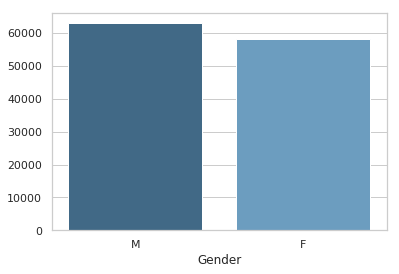

In [7]:
df_gender = df_pd.GENDER.value_counts()
x = df_gender.index.values
y = df_gender.values

sns.set(style="whitegrid")
ax = sns.barplot(x=x, y=y, data=df_pd, palette="Blues_d")
ax.set_xlabel("Gender")

### Now create a visualization to see how the Marital status distribution is in the dataset

In [8]:
# Create Marital Status distribution visualization here

We can also see what is the mutual relation between age, profession and marital status

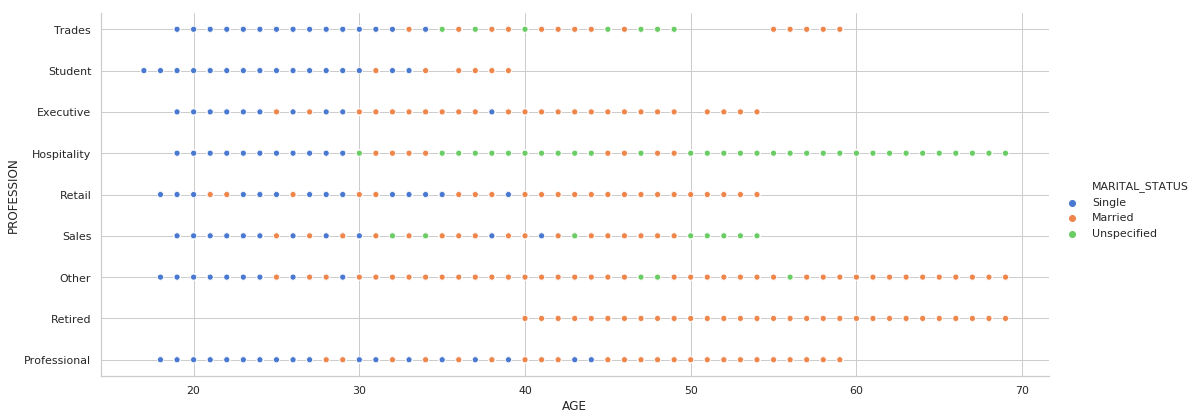

In [9]:
sns.relplot(x="AGE", y="PROFESSION", hue="MARITAL_STATUS", data=df_pd, palette="muted", height=6, aspect=2.5);

We can also see what is the categorical distribution between Profession, Age and Product Line

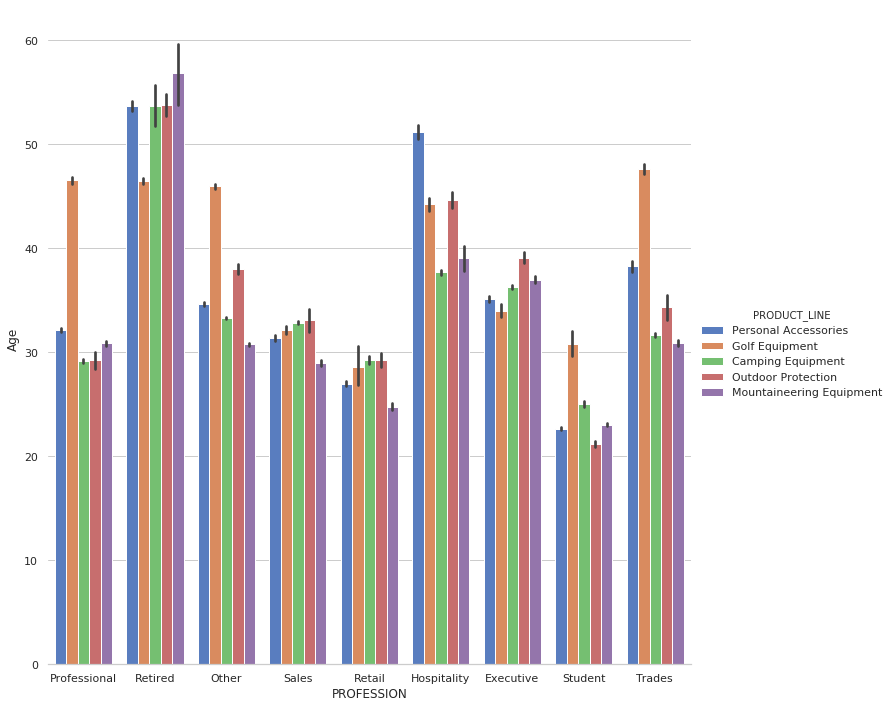

In [10]:
g = sns.catplot(x="PROFESSION", y="AGE", hue="PRODUCT_LINE", data=df_pd,
                height=10, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Age")

<a id="model"></a>
## 4. Build an Apache® Spark machine learning model

In this section, you will learn how to:

- [4.1 Split data](#prep)
- [4.2 Build an Apache® Spark machine learning pipeline](#pipe)
- [4.3 Train a model](#train)

### 4.1 Split data<a id="prep"></a>

In this subsection, you will split your data into: 
- Train data set (80%)
- Test data set (20%)

In [11]:
split_data = df.randomSplit([0.8, 0.02], 24)
train_data = split_data[0]
test_data = split_data[1]

print('Number of training records: ' + str(train_data.count()))
print('Number of testing records : ' + str(test_data.count()))

Number of training records: 118070
Number of testing records : 2920


### You can also try different ratio of split and see how that affects the accuracy of your model

In [12]:
# Try a different split of dataset here

As you can see, your data has been successfully split into two data sets: 

-  The train data set which is the largest group is used for training.
-  The test data set will be used for model evaluation and is used to test the assumptions of the model.

### 4.2 Create the pipeline<a id="pipe"></a>

In this subsection, you will create an Apache® Spark machine learning pipeline and train the model.

In the first step, you need to import the Apache® Spark machine learning modules that will be needed in the subsequent steps.

In [13]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In the following step, use the `StringIndexer` transformer to convert all string fields into numerical type.

In [14]:
stringIndexer_label = StringIndexer(inputCol='PRODUCT_LINE', outputCol='label').fit(df)
stringIndexer_prof = StringIndexer(inputCol='PROFESSION', outputCol='PROFESSION_IX')
stringIndexer_gend = StringIndexer(inputCol='GENDER', outputCol='GENDER_IX')
stringIndexer_mar = StringIndexer(inputCol='MARITAL_STATUS', outputCol='MARITAL_STATUS_IX')

In the following step, create a feature vector to combine all features (predictors) together.

In [15]:
vectorAssembler_features = VectorAssembler(inputCols=['GENDER_IX', 'AGE', 'MARITAL_STATUS_IX', 'PROFESSION_IX'], outputCol='features')

### Next, select the estimator you want to use for classification. `Random Forest` is used in this example.

`Random Forest Classifier` can be used with a wide range of hyperparameters. You can tune them to boost your accuracy.
More details about the available hyperparameters can be found <a  href="http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.classification.RandomForestClassifier" target="_blank" rel="noopener no referrer">here</a>.


### For starters, try giving different values for `numTrees` and `maxDepth`
numTrees = Param(parent='undefined', name='numTrees', doc='Number of trees to train (>= 1).'): Reasonable value between 10 to 50.

maxDepth = Param(parent='undefined', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'). Reasonable value between 5 to 30.

#### But be careful, high number of trees and high maximum depth means more training time and computing resources will be required

In [16]:
rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=, maxDepth=)

Finally, convert the indexed labels back to original labels.

In [17]:
labelConverter = IndexToString(inputCol='prediction', outputCol='predictedLabel', labels=stringIndexer_label.labels)

Now build the pipeline. A pipeline consists of transformers and an estimator.

In [18]:
pipeline_rf = Pipeline(stages=[stringIndexer_label, stringIndexer_prof, stringIndexer_gend, stringIndexer_mar, vectorAssembler_features, rf, labelConverter])

### 4.3 Train a model<a id="train"></a>

Now, you can train your Random Forest model by using the previously defined **pipeline** and **train data**.

In order to train the `Random Forest` model, run the following cell.

In [19]:
model_rf = pipeline_rf.fit(train_data)

Now let us look at which feature has more importance on deciding the outcome

In [20]:
model_rf.stages[5].featureImportances

SparseVector(4, {0: 0.2154, 1: 0.3116, 2: 0.1786, 3: 0.2944})

You can check your **model accuracy** now. Use **test data** to evaluate the model.

In [21]:
predictions = model_rf.transform(test_data)
evaluatorRF = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluatorRF.evaluate(predictions)

print('Accuracy = {:.2f}%'.format(accuracy*100))
print('Test Error = {:.2f}%'.format((1.0 - accuracy)*100))

Accuracy = 60.38%
Test Error = 39.62%


You can tune your model to achieve better accuracy. For simplicity, the tuning step is omitted in this example. Refer to the notebook `Part3: Use Spark and Python to Predict Equipment`.

<a id="persistence"></a>
## 5. Store the model in the WML repository

In this section, you will learn how to use `watson-machine-learning-client` package to store your pipeline and model in the WML repository.

### 5.1 Import required package<a id="lib"></a>

First, you mustimport modules of the `watson-machine-learning-client` package.

**Note**: Python 3.5 and Apache® Spark version >= 2.1 are required.

In [22]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Authenticate the Watson Machine Learning service on the IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://console.bluemix.net/docs/services/service_credentials.html#service_credentials" target="_blank" rel="noopener no referrer">Service credentials</a> tab of the service instance that you created on the IBM Cloud. 

If you cannot find the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your Watson Machine Learning service instance credentials here.

In [23]:
wml_credentials={
    'url': '',
    'username': '',
    'password': '',
    'instance_id': ''
}

In [24]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 5.2 Save the pipeline and model<a id="save"></a>

In this subsection, you will learn how to save pipeline and model artifacts to your Watson Machine Learning instance.

In [25]:
published_model_details = client.repository.store_model(model=model_rf, meta_props={'name':'Product line model with Spark'}, training_data=train_data, pipeline=pipeline_rf)

/opt/ibm/conda/miniconda36/lib/python3.6/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/opt/ibm/conda/miniconda36/lib/python3.6/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [26]:
model_uid = client.repository.get_model_uid(published_model_details)
print(model_uid)

d0716a65-dcaa-4fbf-a86c-e1472a7d0f37


Get saved model metadata from Watson Machine Learning.

**Tip**: Use `client.repository.ModelMetaNames.show()` to get the list of available props.

In [27]:
client.repository.ModelMetaNames.show()

-----------------------  ----  --------
META_PROP NAME           TYPE  REQUIRED
NAME                     str   Y
DESCRIPTION              str   N
AUTHOR_NAME              str   N
FRAMEWORK_NAME           str   N
FRAMEWORK_VERSION        str   N
FRAMEWORK_LIBRARIES      list  N
RUNTIME_NAME             str   N
RUNTIME_VERSION          str   N
TRAINING_DATA_SCHEMA     dict  N
INPUT_DATA_SCHEMA        dict  N
TRAINING_DATA_REFERENCE  dict  N
EVALUATION_METHOD        str   N
EVALUATION_METRICS       list  N
OUTPUT_DATA_SCHEMA       dict  N
LABEL_FIELD              str   N
TRANSFORMED_LABEL_FIELD  str   N
RUNTIME_UID              str   N
TRAINING_DEFINITION_URL  str   N
-----------------------  ----  --------


<a id="scoring"></a>
## 6. Deploy and score in the WML repository

In this section, you will learn how to create an online deployment, create an online scoring endpoint, and score a new data record using the `watson-machine-learning-client` package.

**Note:** You can also use the REST API to deploy and score.
For more information about REST APIs, see the [Swagger Documentation](http://watson-ml-api.mybluemix.net/).

#### Create an online deployment for the published model.

In [28]:
deployment_details = client.deployments.create(model_uid, name='Product line model deployment')



#######################################################################################

Synchronous deployment creation for uid: 'd0716a65-dcaa-4fbf-a86c-e1472a7d0f37' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='10dbc67f-2d06-4279-b400-77677bfe65e6'
------------------------------------------------------------------------------------------------




#### Create an online scoring endpoint. 

In [29]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/a6d14c30-f0b1-4dc9-ace7-0411b5d6c8a2/deployments/10dbc67f-2d06-4279-b400-77677bfe65e6/online


Now, you can send new scoring records (new data) for which you would like to get predictions. To do that, run the following sample code: 

In [30]:
payload_scoring = {'fields': ['GENDER','AGE','MARITAL_STATUS','PROFESSION'],'values': [['M',27,'Single','Student'],['F',68,'Married','Retired']]}

client.deployments.score(scoring_url, payload_scoring)

{'fields': ['GENDER',
  'AGE',
  'MARITAL_STATUS',
  'PROFESSION',
  'PRODUCT_LINE',
  'label',
  'PROFESSION_IX',
  'GENDER_IX',
  'MARITAL_STATUS_IX',
  'features',
  'rawPrediction',
  'probability',
  'prediction',
  'predictedLabel'],
 'values': [['M',
   27,
   'Single',
   'Student',
   'Camping Equipment',
   0.0,
   6.0,
   0.0,
   1.0,
   [0.0, 27.0, 1.0, 6.0],
   [18.486427942806408,
    16.863531932122108,
    10.987103038347813,
    0.44471082923936944,
    3.2182262574843015],
   [0.36972855885612815,
    0.33727063864244217,
    0.21974206076695627,
    0.008894216584787389,
    0.06436452514968603],
   0.0,
   'Camping Equipment'],
  ['F',
   68,
   'Married',
   'Retired',
   'Camping Equipment',
   0.0,
   8.0,
   1.0,
   0.0,
   [1.0, 68.0, 0.0, 8.0],
   [2.518397360403366,
    36.452959986080685,
    1.259254027894454,
    1.9438700364103918,
    7.825518589211092],
   [0.050367947208067324,
    0.7290591997216137,
    0.02518508055788908,
    0.038877400728207834,


As you can see, a 27 year old male student is predicted to be interested in camping equipments (predictedLabel: Camping Equipment). You can also see that a married 68 year old woman is predicted to be interested in Personal Accessories.

<a id="summary"></a>
## 7. Summary and next steps     

You successfully completed this notebook! 
 
You learned how to use Apache® Spark Machine Learning as well as Watson Machine Learning (WML) API client for model creation and deployment. 
 
Check out our [Online Documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html?audience=wdp) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, Ph.D., is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.  
**Jihyoung Kim**, Ph.D., is a Data Scientist at IBM who strives to make data science easy for everyone through Watson Studio.

Copyright © 2017-2019 IBM. This notebook and its source code are released under the terms of the MIT License.